In [2]:
import os
import json
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
# Define the path to your JSON files
RESULTS_PATH = os.path.join(Path.cwd().parent, 'results')
# Function to load all JSON files from the directory
def load_json_files(infer = False):
    data = {}
    for filename in os.listdir(RESULTS_PATH):
        if filename.endswith('.json'):
            if infer and 'infer' in filename:
                with open(os.path.join(RESULTS_PATH, filename), 'r') as file:
                    data.update(json.load(file))
            elif (not infer) and (not 'infer' in filename):
                with open(os.path.join(RESULTS_PATH, filename), 'r') as file:
                    data.update(json.load(file))
                
    return data



In [3]:
ast_insight_data = load_json_files()
ast_insight_df = pd.DataFrame.from_dict(ast_insight_data).transpose()

In [4]:
len(ast_insight_df)

9562

In [5]:
ast_insight_df['suggestions'] = ast_insight_df['suggestions'].apply(lambda x: x if isinstance(x, list) else [])
ast_insight_df['error'] = ast_insight_df['error'].fillna('')
ast_insight_df['suggestions_count'] = ast_insight_df['suggestions'].apply(len)

len(ast_insight_df[ast_insight_df['suggestions_count'] > 0])

1203

In [6]:
len(ast_insight_df[ast_insight_df['status'] != 200])

2777

In [7]:
len(ast_insight_df[ast_insight_df['error'].str.contains('Unary')])

288

In [8]:
infer_data = load_json_files(True)
infer_output_data = {}
infer_output_data = {filename: infer_data[filename]['output'] for filename in infer_data}
infer_df = pd.DataFrame.from_dict(infer_data).transpose()

In [9]:
def count_infer_buffer_overflows_detected(output_list):
    return sum(1 for output in output_list if 'BUFFER_OVERRUN' in output['bug_type'])

In [10]:
infer_df['output'] = infer_df['output'].apply(lambda x: x if isinstance(x, list) else [])
infer_df['error'] = infer_df['error'].fillna('')
infer_df['overflows_detected'] = infer_df['output'].apply(count_infer_buffer_overflows_detected)

In [11]:
len(infer_df[infer_df['overflows_detected'] > 0])

1223

<Figure size 12000x8000 with 0 Axes>

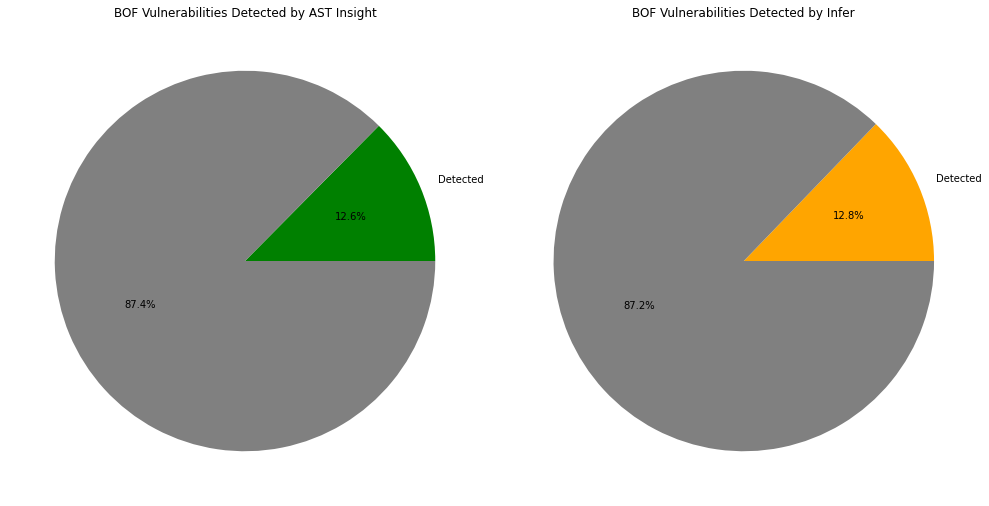

In [18]:
ast_detected = (ast_insight_df['suggestions_count'] > 0).sum()
infer_detected = (infer_df['overflows_detected'] > 0).sum()
total_files_ast = len(ast_insight_df)
total_files_infer = len(infer_df)

ast_labels = ['Detected', '']
ast_sizes = [ast_detected, total_files_ast - ast_detected]

infer_labels = ['Detected', '']
infer_sizes = [infer_detected, total_files_infer - infer_detected]

plt.figure(dpi=2000) 

# Create pie charts
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

# Pie chart for AST Insight
axs[0].pie(ast_sizes, labels=ast_labels, autopct='%1.1f%%', colors=['green', 'gray'])
axs[0].set_title('BOF Vulnerabilities Detected by AST Insight')

# Pie chart for Infer
axs[1].pie(infer_sizes, labels=infer_labels, autopct='%1.1f%%', colors=['orange', 'gray'])
axs[1].set_title('BOF Vulnerabilities Detected by Infer')
plt.savefig('detection_rate.png')
# Display the charts
plt.tight_layout()
plt.show()
